# EcoFOCIpy SBE37 1866 QC

see [EcoFOCIpy_21bsm2a_s37_1866.ipynb](EcoFOCIpy_21bsm2a_s37_1866.ipynb) for initial processing and formatting.  Data would have been convertted from raw instrument format to csv files, initial dirty plots created and a meta-data rich and meta-data poor dataset would have been created.  The metadata poor csv file is used for the initial preliminary data archive, the metadata rich netcdf file is used for QC procedures and eventual final data archive.

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

- **TODO** Programmatically simplify following tools

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import pandas as pd
import xarray as xr
import datetime
import ecofocipy.io.erddap as erddap

import ecofocipy.metaconfig.load_config as load_config

In [95]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2021/Moorings/21bsm2a/'

In [96]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'raw/sbe37/21bsm2a_sbe37_1866_60m.asc'
instrument = 'SBE-37 1866'
mooring_meta_file = user_data_dir+'logs/21BSM-2A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/sbe37_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 's37'
###############################################################

In [97]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [98]:
# this task only needed to be run once in the initial processing routine
# (sbe16_wop_nc.autotrim_time().to_dataframe()).to_csv(filename.replace('nc','csv')) #because the raw archived csv file doesn't trim out deck data, start with this file to edit 

#if it wasn't run, you can ingest the working netcdf file -> export it to csv as it should have been saved as a trimmed file, and work on that csv for manual edits
depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+str(depth).zfill(4)+'m.nc'
sbe37_wop_nc = xr.load_dataset(user_data_dir+'working/'+filename)


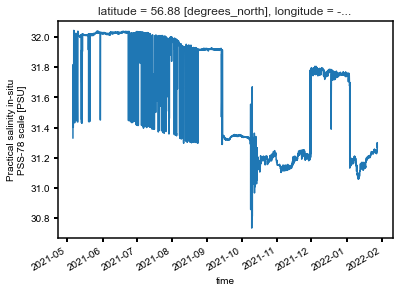

In [99]:
sbe37_wop_nc.salinity.plot()

<div class="alert alert-warning">
  <strong>Something odd gives a step offset? something in flow?</strong>
    <p>
    <ul>Apply three correction periods:
        <li>Deployment to July-01 add 0.585 to any value less than 31.85</li>
        <li>July-01 to Sep-01 add 0.615 to any value less than 31.85</li>
        <li>Sep-01 add 0.575 to any value less than 31.6</li>
    </ul>
    </p>
</div>


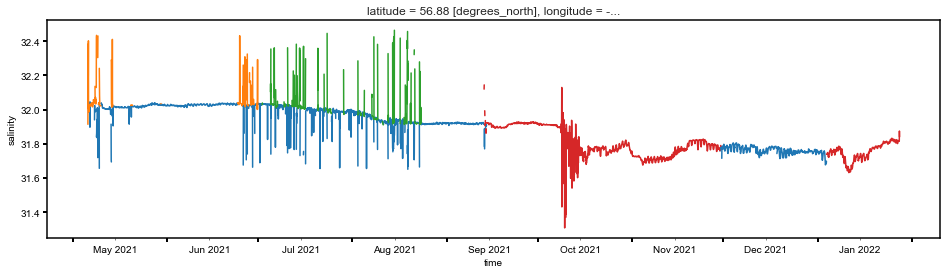

In [100]:
%run '../../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker


fig, ax = plt.subplots(1,figsize=(16, 4),sharex=True)
(sbe37_wop_nc.where(sbe37_wop_nc.salinity >=31.65)).salinity.plot(ax=ax)
(sbe37_wop_nc.sel(time=slice('2021-02','2021-07-01')).where(sbe37_wop_nc.salinity <31.85)+.585).salinity.plot(ax=ax)
(sbe37_wop_nc.sel(time=slice('2021-07-01','2021-09-01')).where(sbe37_wop_nc.salinity <31.85)+.615).salinity.plot(ax=ax)
(sbe37_wop_nc.sel(time=slice('2021-09-01','2022')).where(sbe37_wop_nc.salinity <31.6)+.575).salinity.plot(ax=ax)

# xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_formatter(DateFormatter('%b %Y'))
ax.xaxis.set_major_formatter(DateFormatter(''))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)


In [101]:
sbe37_wop_nc_qcsalt = xr.concat([(sbe37_wop_nc.sel(time=slice('2021-02','2021-06-30')).salinity.where(sbe37_wop_nc.salinity <31.85)+.585),
                                 (sbe37_wop_nc.sel(time=slice('2021-07-01','2021-08-31')).salinity.where(sbe37_wop_nc.salinity <31.85)+.615),
                                 (sbe37_wop_nc.sel(time=slice('2021-09-01','2022')).salinity.where(sbe37_wop_nc.salinity <31.6)+.575)
                              ],dim='time')
sbe37_wop_nc_qcsalt = sbe37_wop_nc_qcsalt.fillna(sbe37_wop_nc.salinity)


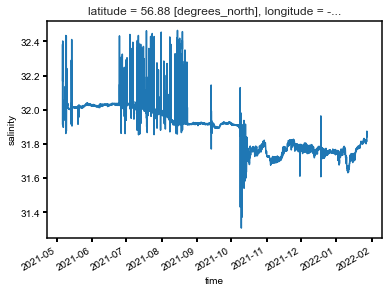

In [102]:
sbe37_wop_nc_qcsalt.plot()

## Try filtering the data to clean up noise

If we break it into two time periods (pre/post Oct 1) we can be more restrictive on the bounds)

In [103]:
import ecofocipy.math.cleaning as cleaning #<- instrument specific
import ecofocipy.math.lanzcos as lanzcos #<- instrument specific
import numpy as np

In [104]:
var_choice = 'salinity'

STDcleaned_1 = cleaning.outlier_bounds_std(sbe37_wop_nc_qcsalt.sel(time=slice('2021-02','2021-09-30')),1.5)
STDcleaned_2 = cleaning.outlier_bounds_std(sbe37_wop_nc_qcsalt.sel(time=slice('2021-10-01','2022-09-30')),3)

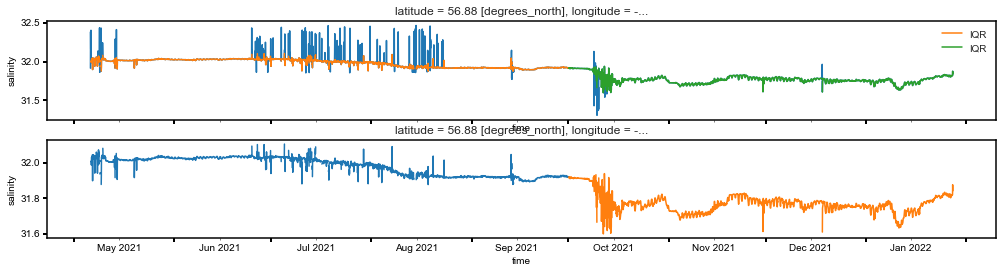

In [105]:
fig, ax = plt.subplots(2,figsize=(17, 4),sharex=True)

sbe37_wop_nc_qcsalt.plot(ax=ax[0])
((sbe37_wop_nc_qcsalt.sel(time=slice('2021-02','2021-09-30')) * 0) + STDcleaned_1).plot(label='IQR',ax=ax[0])
((sbe37_wop_nc_qcsalt.sel(time=slice('2021-10-01','2022-09-30')) * 0) + STDcleaned_2).plot(label='IQR',ax=ax[0])
# ((sbe37_wop_nc_qcsalt[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
# ((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
# sbe37_wop_nc_qcsalt.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)

((sbe37_wop_nc_qcsalt.sel(time=slice('2021-02','2021-09-30')) * 0) + STDcleaned_1).plot(label='IQR',ax=ax[1])
((sbe37_wop_nc_qcsalt.sel(time=slice('2021-10-01','2022-09-30')) * 0) + STDcleaned_2).plot(label='IQR',ax=ax[1])

ax[0].legend()

# xfmt = mdates.DateFormatter('%d-%b')
ax[0].xaxis.set_major_locator(DayLocator(bymonthday=1))
ax[0].xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax[0].xaxis.set_minor_formatter(DateFormatter('%b %Y'))
ax[0].xaxis.set_major_formatter(DateFormatter(''))
ax[0].xaxis.set_tick_params(which='major', pad=3)
ax[0].xaxis.set_tick_params(which='minor', pad=5)


In [106]:
# set values in dataset and export QC'd data
sbe37_wop_nc_filteredsalt = xr.concat([(sbe37_wop_nc_qcsalt.sel(time=slice('2021-02','2021-09-30')).where(sbe37_wop_nc_qcsalt.sel(time=slice('2021-02','2021-09-30')) <0,STDcleaned_1)),
                                       (sbe37_wop_nc_qcsalt.sel(time=slice('2021-10-01','2022-09-30')).where(sbe37_wop_nc_qcsalt.sel(time=slice('2021-10-01','2022-09-30'))<0,STDcleaned_2))
                                      ],dim='time')

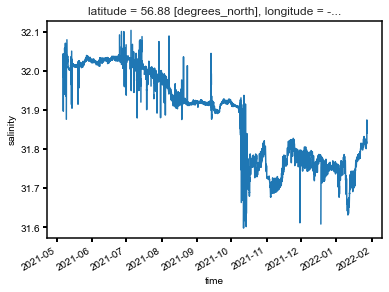

In [107]:
sbe37_wop_nc_filteredsalt.plot()

In [108]:
sbe37_wop_nc_qc = sbe37_wop_nc.copy()

In [109]:
sbe37_wop_nc_qc

<xarray.Dataset>
Dimensions:       (time: 6407, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time          (time) datetime64[ns] 2021-05-06T01:00:00 ... 2022-01-27T23...
  * latitude      (latitude) float64 56.88
  * longitude     (longitude) float64 -164.1
  * depth         (depth) float64 60.0
Data variables:
    temperature   (time, depth, latitude, longitude) float64 2.522 ... 1.109
    conductivity  (time, depth, latitude, longitude) float64 2.828 ... 2.711
    salinity      (time, depth, latitude, longitude) float64 31.33 ... 31.27
Attributes: (12/33)
    Latitude_DegMMddW:                      56 52.52 N
    Longitude_DegMMddN:                     164 04.22 W
    MooringID:                              21BSM-2A
    platform_deployment_date:               2021-05-06T00:01:00Z
    platform_deployment_cruise_name:        DY2103
    platform_recovery_date:                 2022-01-27T23:00:00Z
    ...                                     ...
    InstrumentSerialNumber:                 1866
    InstrumentType:                         SBE-37
    date_created:                           2022-06-15T13:28:30Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.

In [110]:
sbe37_wop_nc_qc['salinity'].values=(sbe37_wop_nc_filteredsalt)

### Update global attributes

In [112]:
sbe37_wop_nc_qc.attrs.update({'QC_indicator': 'ProbablyGood'})
sbe37_wop_nc_qc.attrs.update({'history':(sbe37_wop_nc_qc.history + "\nQCd: "+ str(datetime.datetime.today()))})

In [113]:
sbe37_wop_nc_qc.attrs.update({'date_modified':str(datetime.datetime.today())})

In [114]:
sbe37_wop_nc_qc.to_netcdf(user_data_dir+'working/'+filename,format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})